## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally work on a transformer part.

In [ ]:
# For Colab users
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.insert(0,'/content/drive/{path to project directory}')

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import json

from data_utils import MLDataset, collate_fn
from modeling import Seq2SeqModel

## (Optional) Sample Visualization
You can see actual sample images and correct answers. Additional matplotlib package is needed.

In [2]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

id_to_char = {}
alphabets = "abcdefghijklmnopqrstuvwxyz"
for i, c in enumerate(alphabets):
    id_to_char[i+1] = c

Answer: hear ([8, 5, 1, 18])
Input image sequence:


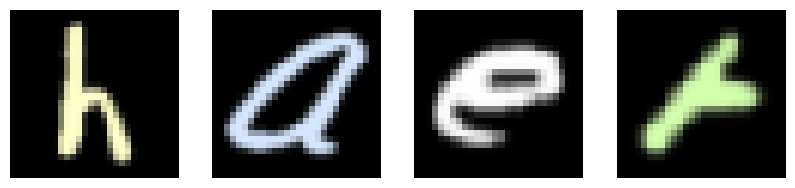

In [3]:
# Just for reference: see actual samples
idx = 1234
sample = np.load(f'./data_final/imgs/train/{idx}.npy')
with open('./data_final/labels/train.json', 'r') as f:
    sample_target = json.load(f)[str(idx)]
    
tgt_char = ""
for i in sample_target:
    tgt_char += id_to_char[i]


print(f"Answer: {tgt_char} ({sample_target})")
print("Input image sequence:")

plt.figure(figsize=(10, len(sample)))
for i, img in enumerate(sample):    
    plt.subplot(1, len(sample), i+1)
    plt.axis("off")
    plt.imshow(img)

In [4]:
## Device and seed setting
assert torch.cuda.is_available()

# # Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2 # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 8

## Model loading and training

In [5]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128

train_ds = MLDataset('data_final/imgs/train', 'data_final/labels/train.json')
valid_ds = MLDataset('data_final/imgs/valid_normal', 'data_final/labels/valid_normal.json')

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

In [6]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 64,   # Hidden dimension size for RNN
    'n_rnn_layers': 2,  # Number of RNN layers
    'rnn_dropout': 0.5, # Dropout rate for RNN
    'rnn_type': 'GRU', # Type of RNN ('LSTM' or 'GRU')
    'cnn_settings': {   # Settings for the CustomCNN
        'block1_dim': 32,
        'block2_dim': 64,
        'block3_dim': 128,
        'fc_dim': 64,
        'model_type': 'VGG'  # Type of CNN ('VGG' or 'ResNet')
    },
    'encoder_bidirectional': True  # Whether the encoder RNN is bidirectional
}

In [7]:
model = Seq2SeqModel(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
# model_optim = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
model_optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(model_optim, step_size=10, gamma=0.5)
# NOTE: you can define additional components like lr_scheduler, ...
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Seq2SeqModel(
  (encoder): Encoder(
    (cnn): CustomCNN(
      (block1): VGGBlock(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (block2): VGGBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (block3): VGGBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (fc): Linear(in_features=1152, out_features=64, bias=True)
  

In [8]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 1000
max_epoch = 20
patience = 2
vis = True

In [9]:
def train(
        model,
        model_optim,
        loss_fn,
        max_epoch,
        train_dl,
        valid_dl,
        load_path=None,
        save_path='./model.pt',
        patience=5,
    ):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]
        # ...
        
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    best_valid_loss = 1e+10 if loaded_best_valid_loss == -1 else loaded_best_valid_loss

    #NOTE: Added early stopping
    no_improvement_epochs = 0

    # Initialize lists to store loss values
    train_losses = []
    valid_losses = []
    accuracies = []

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        step = 0
        train_loss = 0
        model.train()

        for batch_idx, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data = data.to(device) # (B, T, H, W, C)
            target = target.to(device) # (B, T)
            
            # start tokens should be located at the first position of the decoder input
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 5: implement loss calculation and optimization part
            # You can utilize teacher-forcing strategy to this part
            model_optim.zero_grad()
            
            # Implement teacher forcing
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)
            logits, hidden_state = model(data, lengths, decoder_input)

            # Reshape logits and target for CrossEntropyLoss
            # logits shape: (B, T, C) -> (B * T, C)
            # target shape: (B, T) -> (B * T)

            # Calculate loss
            logits = logits.view(-1, logits.size(-1))
            target = target.view(-1)
            loss = loss_fn(logits, target)

            # Backward propagation
            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update model parameters
            model_optim.step()
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            train_loss += loss.detach().cpu().item()
            step += 1
            if (batch_idx + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.detach().cpu().item())
                
        train_loss_avg = train_loss / (batch_idx+1)
        
        # Log the average training loss for this epoch
        train_losses.append(train_loss_avg)
        
        print(f"epoch {epoch + 1}, train loss: {train_loss_avg}")

        # Step the scheduler
        scheduler.step()

        valid_loss = 0
        correct_sequences = 0
        total_sequences = 0

        model.eval()
        
        for batch_idx, (data, target, lengths) in enumerate(tqdm(valid_dl)):            
            with torch.no_grad():
                data = data.to(device) # (B, T, H, W, C)
                target = target.to(device) # (B, T)
                
                # start tokens should be located at the first position of the decoder input
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Decoder input should be the target sequence without the last token
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)
                
                # Implement loss calculation for valid batch (same as problem 5)
                logits, _ = model(data, lengths, decoder_input)
                
                # Reshape logits and target for CrossEntropyLoss
                logits = logits.view(-1, logits.size(-1))
                target = target.view(-1)
                loss = loss_fn(logits, target)

                # Calculate sequence-level accuracy
                logits = logits.view(data.size(0), -1, logits.size(-1))
                predicted_sequences = torch.argmax(logits, dim=-1)
                for i in range(data.size(0)):
                    pred_seq = predicted_sequences[i][:int(lengths[i])]
                    target_seq = target.view(data.size(0), -1)[i][:int(lengths[i])]
                    if torch.equal(pred_seq, target_seq):
                        correct_sequences += 1
                    total_sequences += 1
                ##########################F####################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                valid_loss += loss.cpu().item()
        valid_loss /= (batch_idx + 1)
        accuracy = correct_sequences / total_sequences
        accuracies.append(accuracy)

        # Log the average validation loss for this epoch
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Save your states
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": best_valid_loss,
                # ...
            }
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            torch.save(state, save_path)
            best_valid_loss = valid_loss

            # Reset no improvement epochs
            no_improvement_epochs = 0
        else:
            # Increment no improvement epochs (early stopping)
            no_improvement_epochs += 1

        print('valid epoch: %d, valid loss: %.4f, best valid loss: %.4f' % (epoch + 1, valid_loss, best_valid_loss))

        # If no improvement seen above patience, stop training (early stopping)
        if no_improvement_epochs >= patience:
            print("No improvement in validation loss for {} epochs. Stopping training.".format(patience))
            break

    return train_losses, valid_losses, accuracies

In [10]:
load_path = None
train_losses, valid_losses, accuracies = train(
    model,
    model_optim,
    loss_fn,
    max_epoch,
    train_dl,
    valid_dl,
    load_path=load_path,
    save_path='./model.pt',
    patience=patience,
)

100%|██████████| 531/531 [01:01<00:00,  8.59it/s]


epoch 1, train loss: 2.5748605041180626


100%|██████████| 76/76 [00:04<00:00, 17.09it/s]


New best valid loss, saving model
valid epoch: 1, valid loss: 2.7515, best valid loss: 2.7515


100%|██████████| 531/531 [01:02<00:00,  8.53it/s]


epoch 2, train loss: 2.2085903081516762


100%|██████████| 76/76 [00:04<00:00, 17.03it/s]


New best valid loss, saving model
valid epoch: 2, valid loss: 2.0871, best valid loss: 2.0871


100%|██████████| 531/531 [01:02<00:00,  8.54it/s]


epoch 3, train loss: 1.5598651934029244


100%|██████████| 76/76 [00:04<00:00, 17.10it/s]


New best valid loss, saving model
valid epoch: 3, valid loss: 1.3036, best valid loss: 1.3036


100%|██████████| 531/531 [01:02<00:00,  8.52it/s]


epoch 4, train loss: 0.9571961042122203


100%|██████████| 76/76 [00:04<00:00, 16.80it/s]


New best valid loss, saving model
valid epoch: 4, valid loss: 0.7338, best valid loss: 0.7338


100%|██████████| 531/531 [01:02<00:00,  8.51it/s]


epoch 5, train loss: 0.6264984724436327


100%|██████████| 76/76 [00:04<00:00, 17.08it/s]


New best valid loss, saving model
valid epoch: 5, valid loss: 0.5252, best valid loss: 0.5252


100%|██████████| 531/531 [01:02<00:00,  8.52it/s]


epoch 6, train loss: 0.4800461272510881


100%|██████████| 76/76 [00:04<00:00, 17.20it/s]


New best valid loss, saving model
valid epoch: 6, valid loss: 0.4141, best valid loss: 0.4141


100%|██████████| 531/531 [01:02<00:00,  8.53it/s]


epoch 7, train loss: 0.3967010524762328


100%|██████████| 76/76 [00:04<00:00, 16.91it/s]


New best valid loss, saving model
valid epoch: 7, valid loss: 0.3412, best valid loss: 0.3412


100%|██████████| 531/531 [01:02<00:00,  8.54it/s]


epoch 8, train loss: 0.3398690327524914


100%|██████████| 76/76 [00:04<00:00, 17.14it/s]


New best valid loss, saving model
valid epoch: 8, valid loss: 0.2996, best valid loss: 0.2996


100%|██████████| 531/531 [01:02<00:00,  8.52it/s]


epoch 9, train loss: 0.3037867374900595


100%|██████████| 76/76 [00:04<00:00, 16.55it/s]


New best valid loss, saving model
valid epoch: 9, valid loss: 0.2738, best valid loss: 0.2738


100%|██████████| 531/531 [01:02<00:00,  8.54it/s]


epoch 10, train loss: 0.2738356311049614


100%|██████████| 76/76 [00:04<00:00, 17.09it/s]

New best valid loss, saving model
valid epoch: 10, valid loss: 0.2521, best valid loss: 0.2521


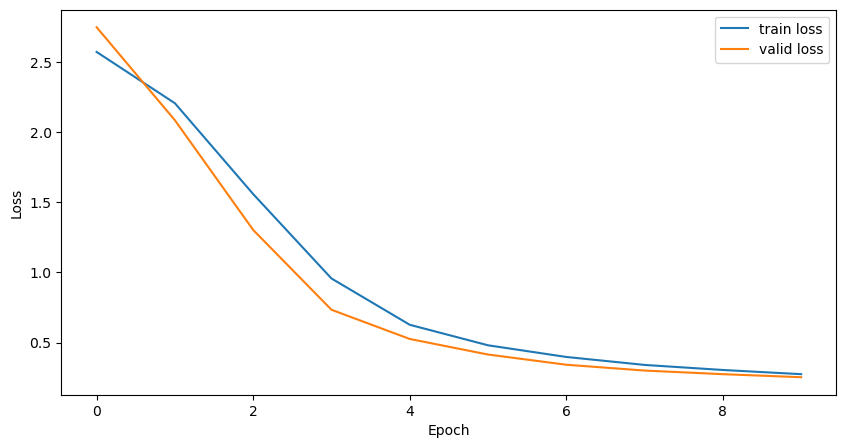

In [11]:
# Plot the training and validation losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

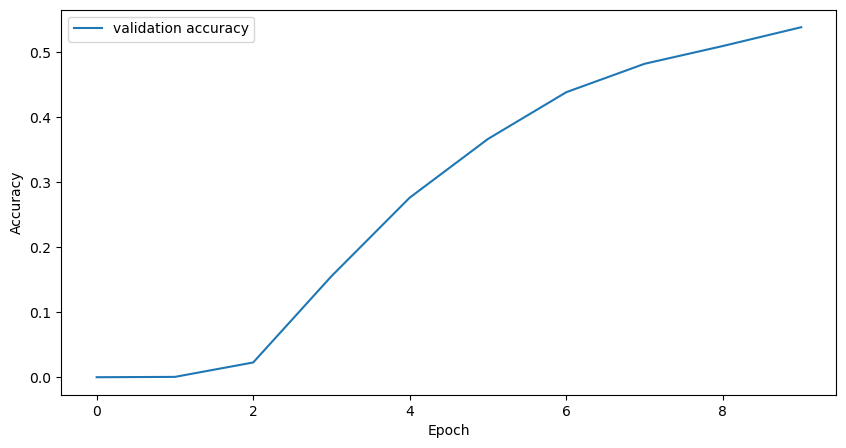

In [12]:
# Plot the validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Do not modify this cell!

def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i+1] = c

    results = []
    labels = []    
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):       
        data = data.to(device) # (B, T, H, W, C)
        target = target.to(device) # (B, T)
        
        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
        with torch.no_grad():
            generated_tok = model.generate(data, lengths, start_tokens, **kwargs_generate) # (B, T)
        
        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            results.append(decoded)
    
            decoded = ""
            for j in target[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)
        
    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [14]:
# load and evaluate your model
load_path = './model.pt'
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

Evaluation with validation set


  0%|          | 0/76 [00:00<?, ?it/s]


NameError: name 'kwargs_generate' is not defined